<a href="https://colab.research.google.com/github/davkeem/SHAZAM-CAPSTONE/blob/main/final_model_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os


drive.mount('/content/drive')

hist_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/hist_data'


chroma_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/dataset_processed/processed_chroma/ml_processed_data'
harmonic_data_folder ='/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/dataset_processed/processed_harmonic/ml_processed_data'
mfcc_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/mfcc'
onset_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/dataset_processed/processed_onset/ml_processed_data'
percussive_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/dataset_processed/processed_percussive/ml_processed_data'
spectral_centroid_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/dataset_processed/processed_spectral_centroid/ml_processed_data'
spectral_contrast_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/dataset_processed/processed_spectral_contrast/ml_processed_data'
tempo_beats_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/dataset_processed/processed_tempo_beats/ml_processed_data'


Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

def load_data(directory):
    data = []
    for file_name in sorted(os.listdir(directory)):
        if file_name.endswith('.csv'):
            file_path = os.path.join(directory, file_name)
            df = pd.read_csv(file_path, header=None, skiprows=1)
            # Clean the data to remove brackets and convert to float
            df = df.replace(r'[\[\]]', '', regex=True).astype(float) #Tempo beats data has brackets
            data.append(df.iloc[:, 1:].values)  # Exclude the time bin column
    max_length = max(array.shape[0] for array in data)  # Find the max length
    padded_data = pad_sequences(data, maxlen=max_length, padding='post', dtype='float32')  # Pad sequences
    return np.array(padded_data)

# Load data from all specified folders
mfcc_data = load_data(mfcc_data_folder)
hist_data = load_data(hist_data_folder)
chroma_data = load_data(chroma_data_folder)
harmonic_data = load_data(harmonic_data_folder)
onset_data = load_data(onset_data_folder)
percussive_data = load_data(percussive_data_folder)
spectral_centroid_data = load_data(spectral_centroid_data_folder)
spectral_contrast_data = load_data(spectral_contrast_data_folder)
tempo_beats_data = load_data(tempo_beats_data_folder)

# Combine all features into X for the ablation study
all_features = {
    "mfcc": mfcc_data,
    "chroma": chroma_data,
    "harmonic": harmonic_data,
    "onset": onset_data,
    "percussive": percussive_data,
    "spectral_centroid": spectral_centroid_data,
    "spectral_contrast": spectral_contrast_data,
    "tempo_beats": tempo_beats_data,
}

# Concatenate all features into a single array
X = np.concatenate(list(all_features.values()), axis=2)  # Combine along feature axis
y = hist_data

print(f"X shape: {X.shape}")  # Combined features
print(f"y shape: {y.shape}")  # Target histogram





X shape: (20, 550, 70)
y shape: (20, 550, 1)


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from statistics import mean, stdev

# Dictionary to store ablation study results
ablation_results = {}

# Number of repetitions for averaging
num_repeats = 5

# Iterate over each feature set
for feature_name, feature_data in all_features.items():
    print(f"Evaluating feature: {feature_name}")
    losses = []  # Store losses for all repetitions

    # LOO cross-validator
    loo = LeaveOneOut()

    for repeat in range(num_repeats):
        print(f"  Repetition {repeat + 1}/{num_repeats}")
        fold_losses = []  # Losses for each fold in this repetition

        # Iterate through LOO folds
        for train_index, test_index in loo.split(feature_data):
            X_train, X_test = feature_data[train_index], feature_data[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Define the model
            model = Sequential()
            model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
            model.add(MaxPooling1D(pool_size=2))
            model.add(Dropout(0.3))
            model.add(Conv1D(128, kernel_size=3, activation='relu'))
            model.add(MaxPooling1D(pool_size=2))
            model.add(Dropout(0.3))
            model.add(Flatten())
            model.add(Dense(X_train.shape[1], activation='linear'))
            model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

            # Train the model
            model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)  # Verbose=0 for cleaner output

            # Evaluate the model
            loss = model.evaluate(X_test, y_test, verbose=0)
            fold_losses.append(loss)

        # Store the average loss for this repetition
        repetition_avg_loss = mean(fold_losses)
        losses.append(repetition_avg_loss)

    # Store the overall average and standard deviation of losses
    avg_loss = mean(losses)
    std_loss = stdev(losses)
    ablation_results[feature_name] = (avg_loss, std_loss)
    print(f"Feature: {feature_name} - Avg Test MSE: {avg_loss:.4f} ± {std_loss:.4f}")


Evaluating feature: mfcc
  Repetition 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Repetition 2/5


KeyboardInterrupt: 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from statistics import mean, stdev

# Dictionary to store ablation study results
ablation_results = {}

# Number of repetitions for averaging
num_repeats = 5

# Iterate over each feature set
for feature_name, feature_data in all_features.items():
    print(f"Evaluating feature: {feature_name}")
    losses = []  # Store losses for all repetitions

    for repeat in range(num_repeats):
        print(f"  Repetition {repeat + 1}/{num_repeats}")

        # Use only the current feature for training
        X_feature = feature_data

        # Split into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_feature, y, test_size=0.2, random_state=repeat)

        # Define the model
        model = Sequential()
        model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.3))
        model.add(Conv1D(128, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.3))
        model.add(Flatten())
        model.add(Dense(X_train.shape[1], activation='linear'))
        model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

        # Train the model
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)  # Verbose=0 for cleaner output

        # Evaluate the model
        loss = model.evaluate(X_test, y_test, verbose=0)
        losses.append(loss)

    # Store the average and standard deviation of losses
    avg_loss = mean(losses)
    std_loss = stdev(losses)
    ablation_results[feature_name] = (avg_loss, std_loss)
    print(f"Feature: {feature_name} - Avg Test MSE: {avg_loss:.4f} ± {std_loss:.4f}")


Evaluating feature: mfcc
  Repetition 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Repetition 2/5
  Repetition 3/5
  Repetition 4/5


  Repetition 5/5


Feature: mfcc - Avg Test MSE: 2363748.2250 ± 250339.0463
Evaluating feature: chroma
  Repetition 1/5
  Repetition 2/5
  Repetition 3/5
  Repetition 4/5
  Repetition 5/5
Feature: chroma - Avg Test MSE: 2436419.7500 ± 319015.6662
Evaluating feature: harmonic
  Repetition 1/5
  Repetition 2/5
  Repetition 3/5
  Repetition 4/5
  Repetition 5/5
Feature: harmonic - Avg Test MSE: 2256915.2000 ± 399165.2823
Evaluating feature: onset
  Repetition 1/5
  Repetition 2/5
  Repetition 3/5
  Repetition 4/5
  Repetition 5/5
Feature: onset - Avg Test MSE: 2155473.0250 ± 442153.3349
Evaluating feature: percussive
  Repetition 1/5
  Repetition 2/5
  Repetition 3/5
  Repetition 4/5
  Repetition 5/5
Feature: percussive - Avg Test MSE: 2105456.8750 ± 571910.8533
Evaluating feature: spectral_centroid
  Repetition 1/5
  Repetition 2/5
  Repetition 3/5
  Repetition 4/5
  Repetition 5/5
Feature: spectral_centroid - Avg Test MSE: 987463.6750 ± 250658.9056
Evaluating feature: spectral_contrast
  Repetition 1/5
  

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Fold 1: Leaving out song at index 0
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 8445204.0000
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step - loss: 8405636.0000
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 3765686.2500
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 2273399.5000
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 2655626.5000
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 2957617.2500
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 2929216.7500
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 2670274.2500
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 2255637.0000
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 1756895.1250
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 1305056.8750
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 936839.0625
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 889790.5000
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22

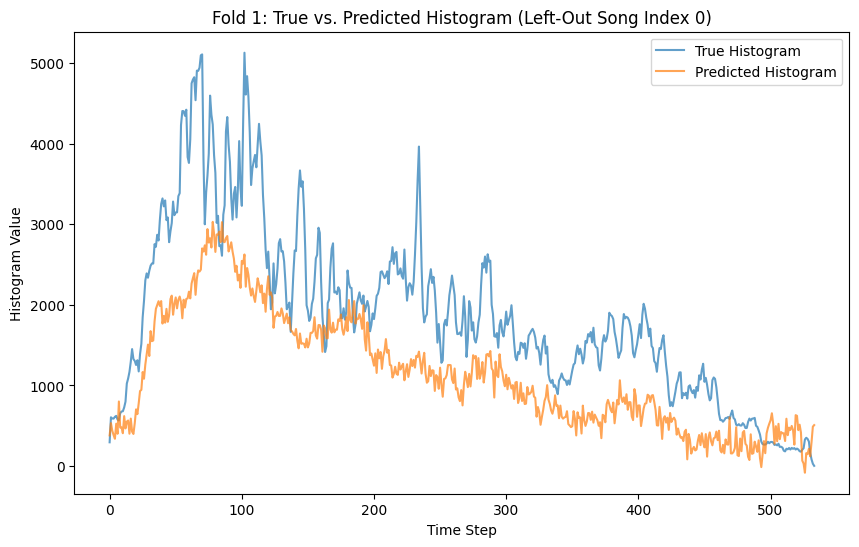

Fold 2: Leaving out song at index 1
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 526737.9375
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 486172.0625
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 426817.5312
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 399044.1562
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 383526.7188
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 390886.6562
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step - loss: 372230.9062
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - loss: 367927.7188
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step - loss: 328003.5625
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step - loss: 301886.5625
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step - loss: 303550.4062
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - loss: 270862.4375
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - loss: 259636.1875
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step

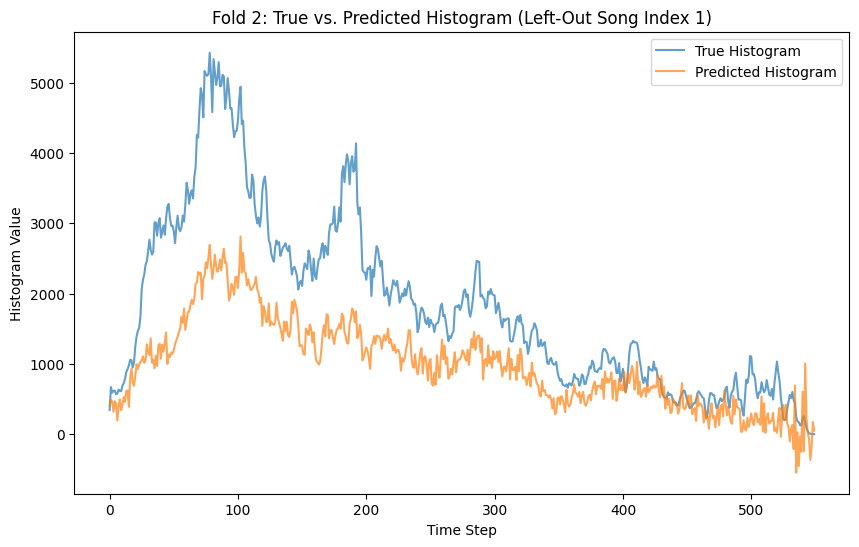

Fold 3: Leaving out song at index 2
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - loss: 128842.6562
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 117773.7734
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: 122929.8125
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 116755.6875
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 108670.1250
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 108669.9922
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 104961.7031
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 106208.4531
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 98234.3828
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 91498.2344
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 96009.9297
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 93747.4766
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 96326.3516
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - lo

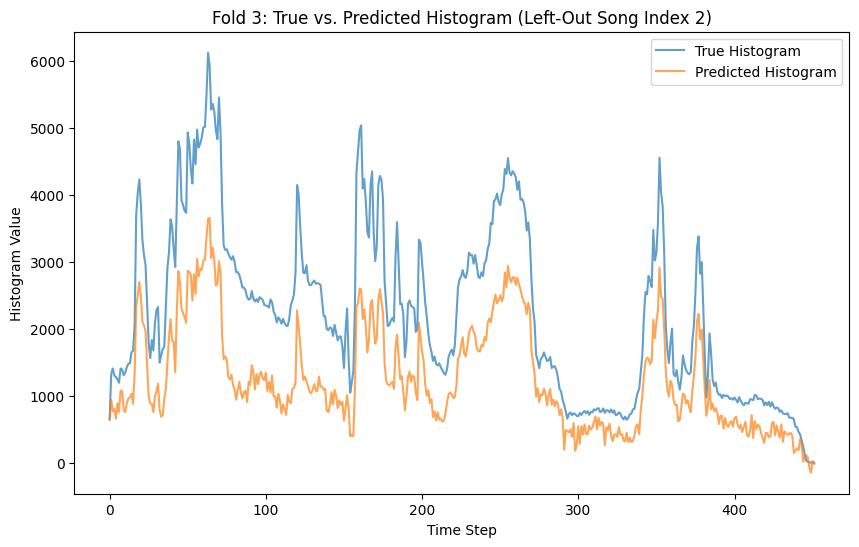

Fold 4: Leaving out song at index 3
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 70506.6172
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 68093.7812
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - loss: 70369.1016
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 71787.3438
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - loss: 66283.4609
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step - loss: 67738.7422
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - loss: 66787.1719
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step - loss: 64691.8281
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 67668.9609
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 66979.1406
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 65353.1328
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 63562.1133
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 64559.7617
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 6007

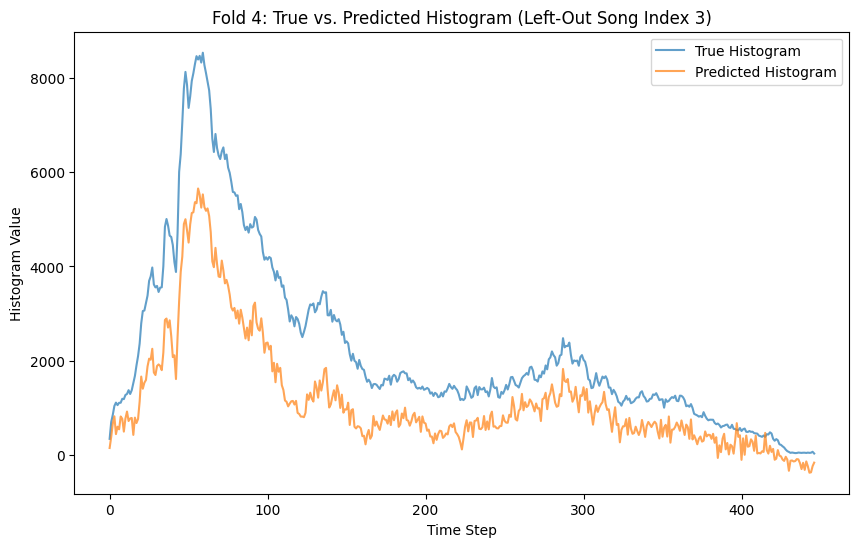

Fold 5: Leaving out song at index 4
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - loss: 58024.3242
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - loss: 62479.6836
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step - loss: 66633.8906
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step - loss: 56494.8008
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - loss: 54790.7852
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - loss: 53232.9102
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 57114.6836
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 51838.5898
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 54188.9609
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 53335.6133
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 55992.1641
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 52343.2148
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 53155.9492
Test MSE for this fold: 1385855.625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

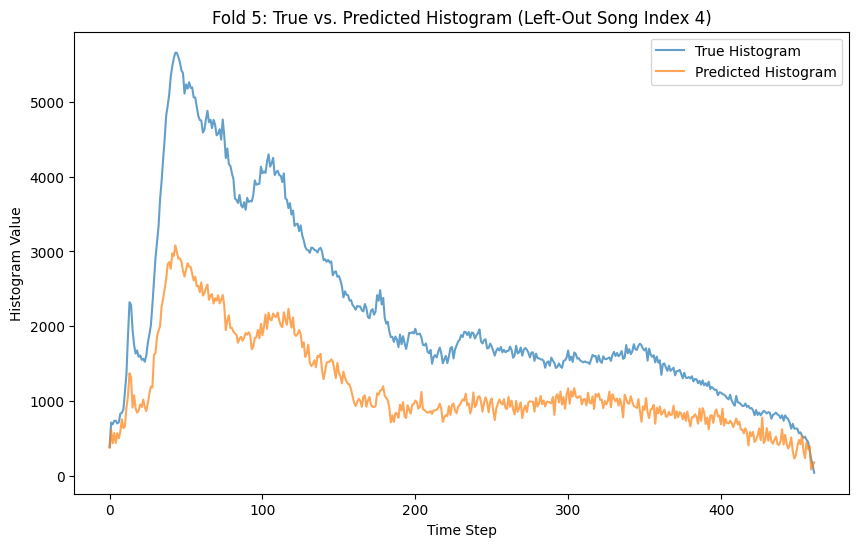

Fold 6: Leaving out song at index 5
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 55837.5273
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 55565.0117
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 55856.1758
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 52680.9727
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 53891.8672
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 51290.2578
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 50992.9727
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 51963.3516
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 48406.9062
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 54483.6797
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 49950.5898
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 55945.0938
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 53471.1016
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 5329

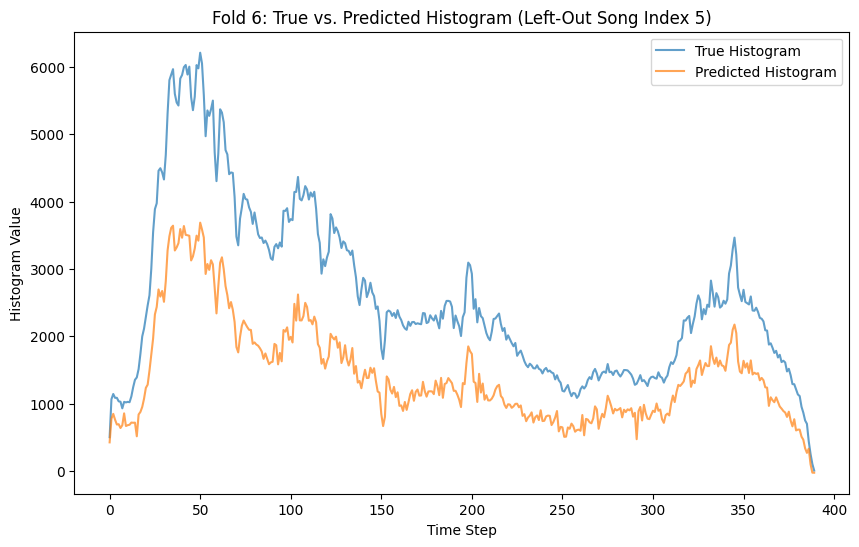

Fold 7: Leaving out song at index 6
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 54642.8359
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 48201.7188
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 51624.4883
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 53827.0039
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 50738.4453
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 50303.6875
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 53658.6211
Test MSE for this fold: 1242649.875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Test RMSE for this fold: 1114.7420654296875


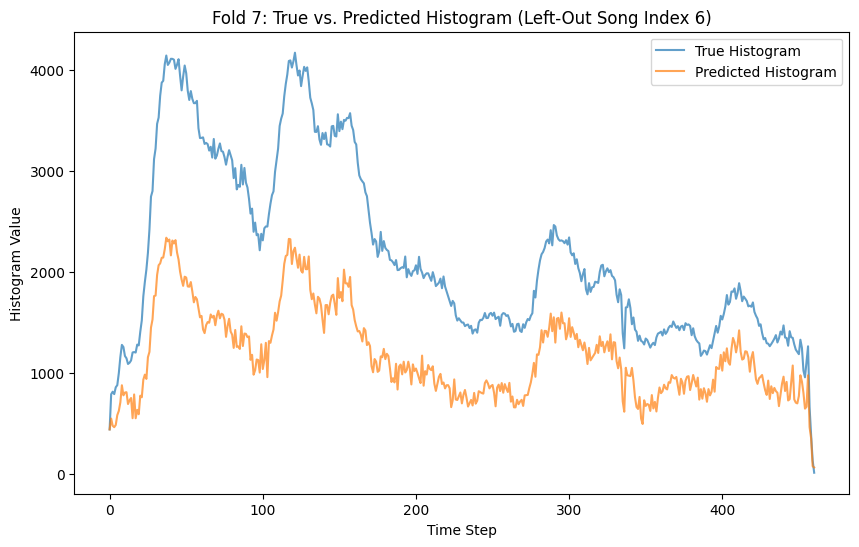

Fold 8: Leaving out song at index 7
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 47189.7812
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - loss: 47514.4727
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - loss: 47894.3828
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step - loss: 52347.0508
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step - loss: 46622.0781
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step - loss: 47245.5703
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step - loss: 46725.2344
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step - loss: 48354.4375
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - loss: 47068.8477
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - loss: 44278.7109
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step - loss: 44215.9766
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 45772.8555
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 46587.8555
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 4529

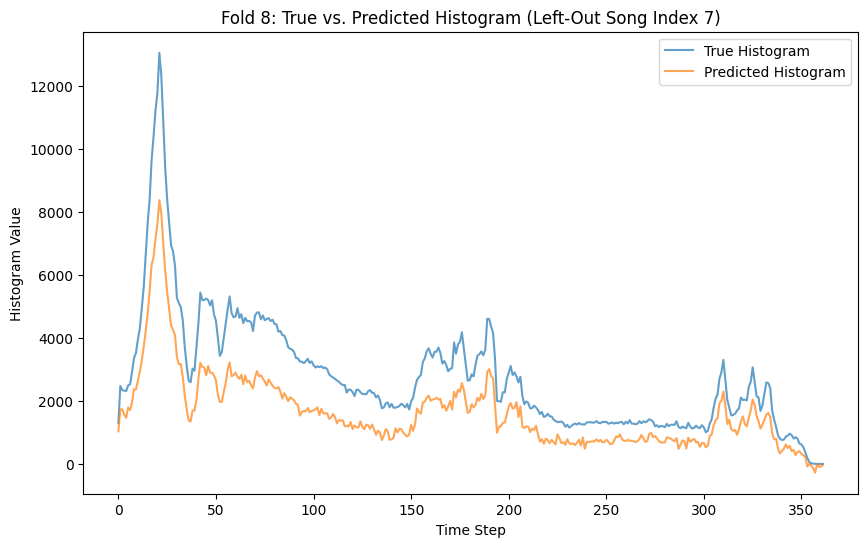

Fold 9: Leaving out song at index 8
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 44566.5234
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 48652.7891
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 45279.4570
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 43877.5742
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - loss: 43581.1758
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 43312.6875
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 41558.6172
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 43063.9492
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - loss: 44072.1758
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 46537.8477
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 45315.4531
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 43343.4648
Test MSE for this fold: 1120969.25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test RMSE for this fold: 1058.75830078125


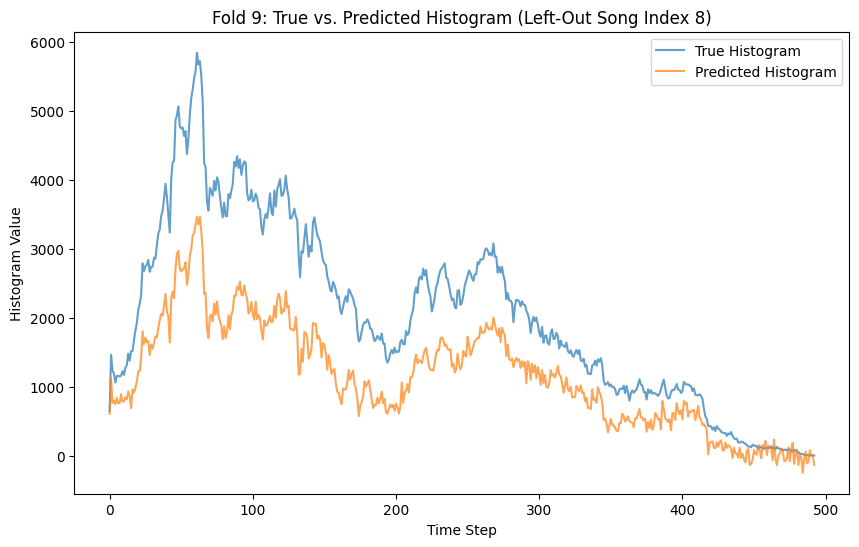

Fold 10: Leaving out song at index 9
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - loss: 42794.3203
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step - loss: 39771.2344
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - loss: 39489.9531
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step - loss: 39047.0508
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step - loss: 39109.6914
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step - loss: 41973.6914
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step - loss: 41900.8672
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - loss: 37983.6172
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - loss: 42653.4922
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - loss: 38692.3438
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 39002.9102
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 37579.3477
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 37469.3164
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 374

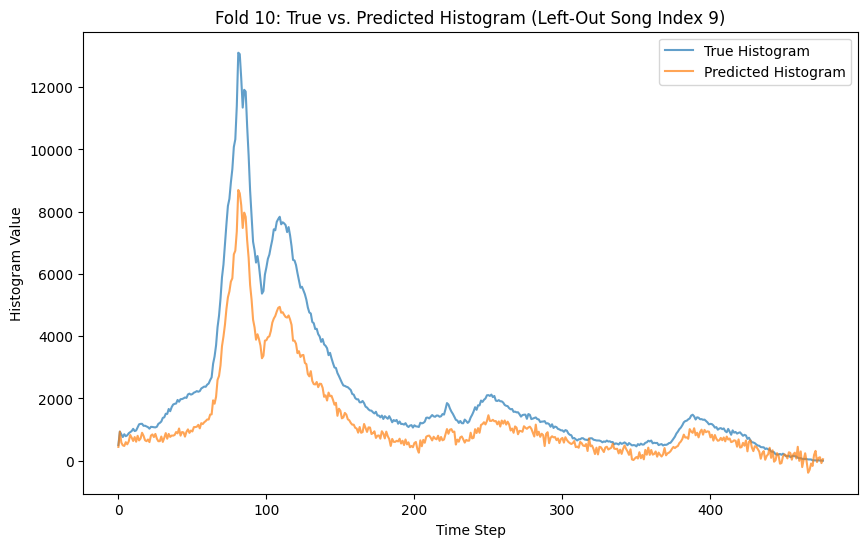

Fold 11: Leaving out song at index 10
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 34755.4141
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 37941.1562
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 35722.8789
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 35151.0117
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 37799.3477
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 38615.5938
Test MSE for this fold: 1338362.25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Test RMSE for this fold: 1156.8760986328125


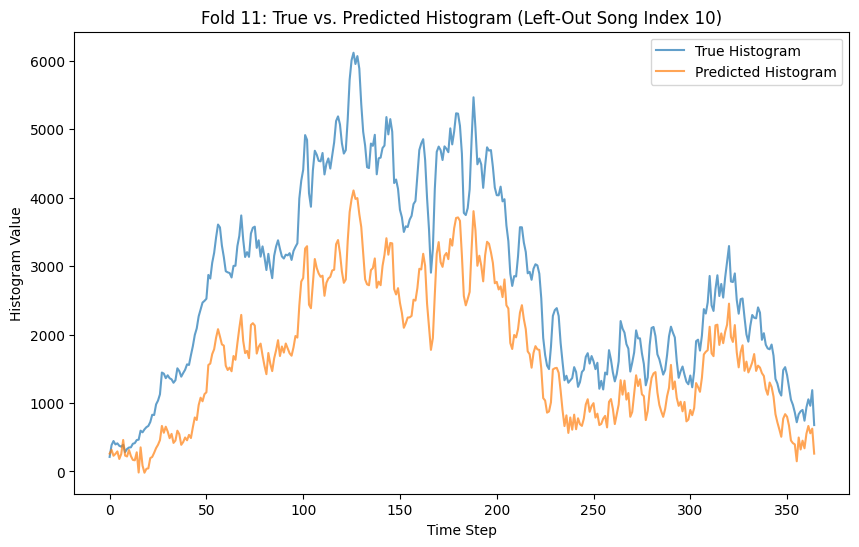

Fold 12: Leaving out song at index 11
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 35756.7500
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 39434.9961
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 38147.4766
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - loss: 38558.3906
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 34341.7969
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 35149.6289
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - loss: 34587.0977
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - loss: 35830.3477
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step - loss: 34475.8711
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step - loss: 33085.0586
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - loss: 34707.3633
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step - loss: 33483.8086
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - loss: 33446.7266
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - loss: 34

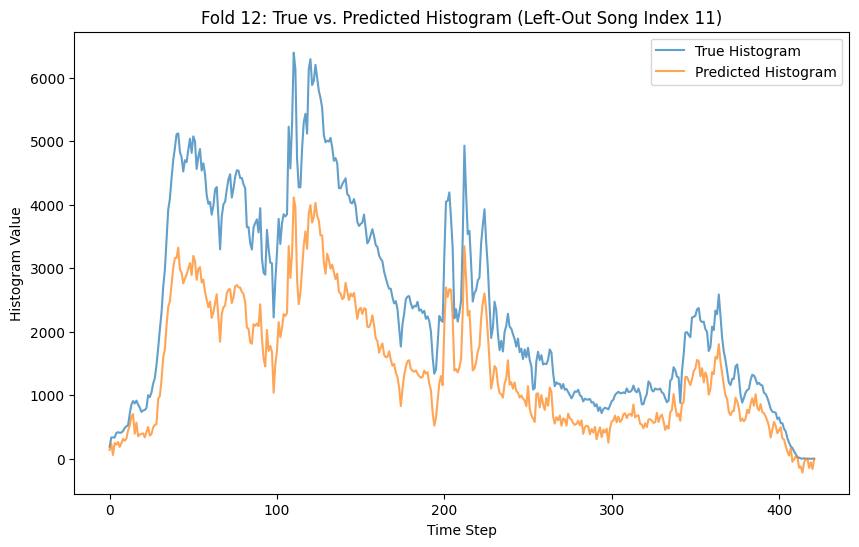

Fold 13: Leaving out song at index 12
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 36528.5547
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 32788.8789
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - loss: 37746.7930
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 35586.2031
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 35004.6797
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 35964.0625
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 35010.0508
Test MSE for this fold: 911066.4375
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Test RMSE for this fold: 954.4979858398438


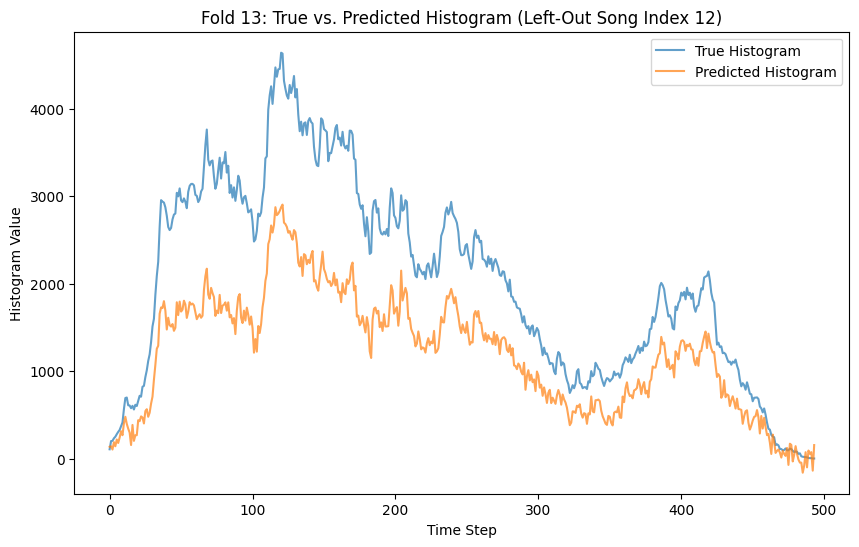

Fold 14: Leaving out song at index 13
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 32272.9941
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 30993.0918
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 38289.4492
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 35653.9414
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 35731.1602
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 32394.7305
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 32191.9941
Test MSE for this fold: 1014090.3125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test RMSE for this fold: 1007.0204467773438


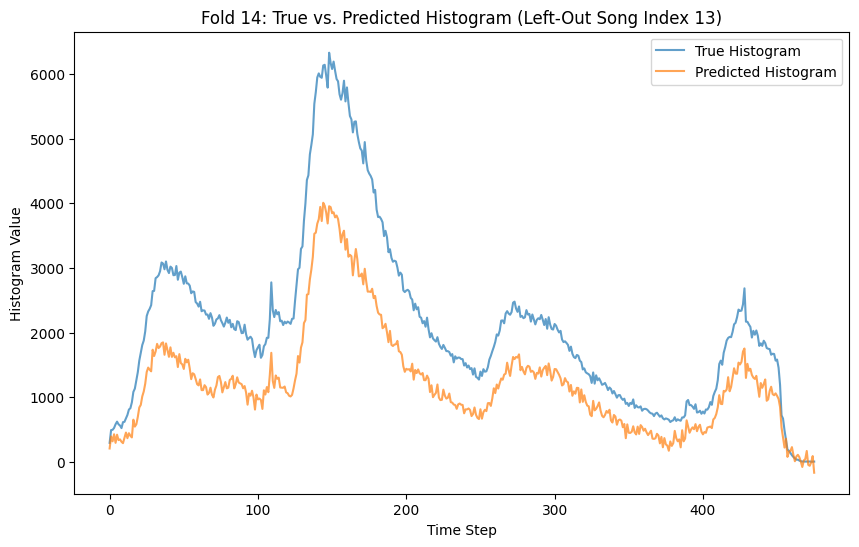

Fold 15: Leaving out song at index 14
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 35239.2656
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 29551.8281
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 32042.1836
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 35737.4336
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 30706.4512
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 31511.1094
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - loss: 35386.5781
Test MSE for this fold: 1518907.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Test RMSE for this fold: 1232.439453125


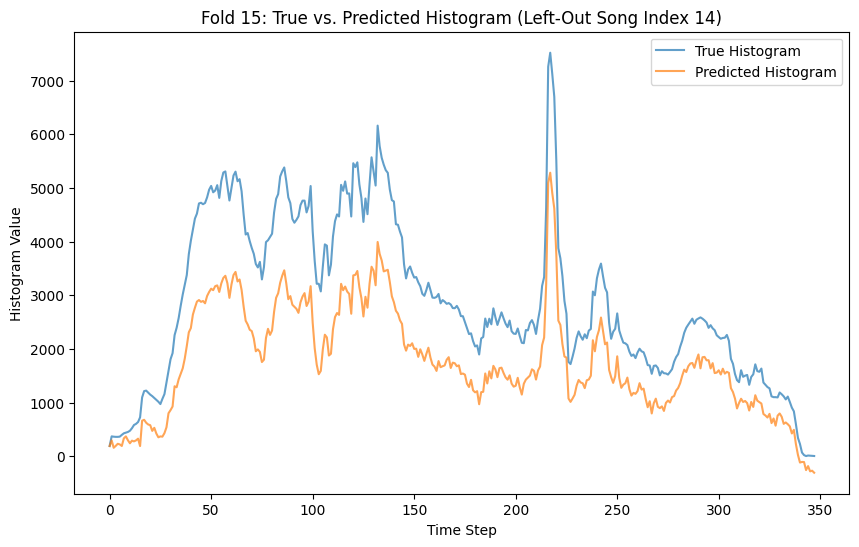

Fold 16: Leaving out song at index 15
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 33646.1875
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 35813.0078
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 32076.9512
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 33316.5234
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 30272.1582
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 36716.4258
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 34445.3867
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 34708.4141
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - loss: 30718.5039
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - loss: 30466.4082
Test MSE for this fold: 1155901.125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Test RMSE for this fold: 1075.12841796875


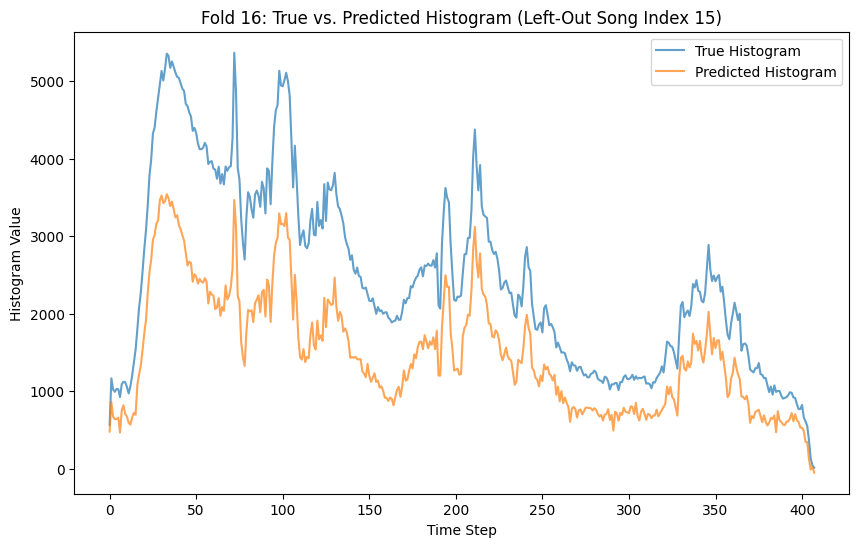

Fold 17: Leaving out song at index 16
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - loss: 29581.2129
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - loss: 31642.3281
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - loss: 30704.3281
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - loss: 31381.3906
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - loss: 29201.3027
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - loss: 31135.3711
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - loss: 32812.3789
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - loss: 28368.4766
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - loss: 32461.5859
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step - loss: 29938.3262
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 30917.7402
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 30322.2012
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 31305.8496
Test MSE for this fold: 1068745.875
1/1 ━━━━━━━━━━━━━━━━━━━━ 

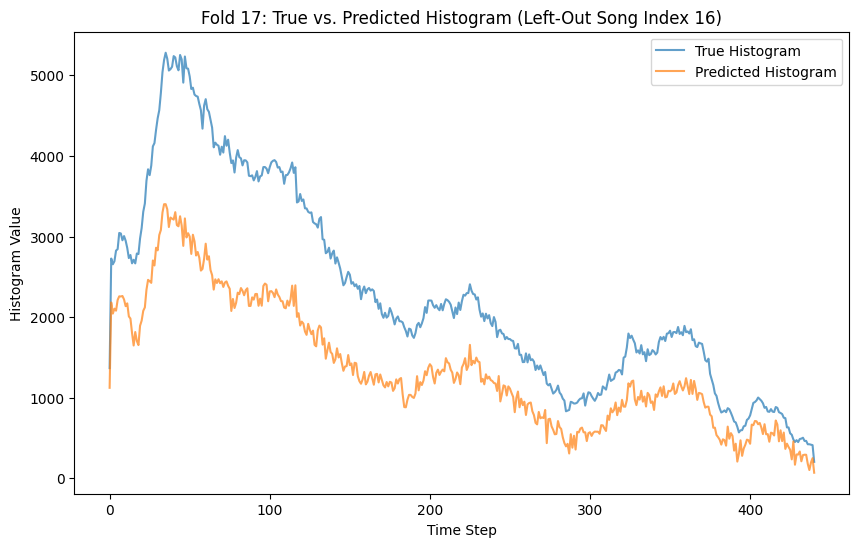

Fold 18: Leaving out song at index 17
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 29165.7734
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 30866.4004
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 28850.7070
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 28824.0684
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 29373.5996
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 30036.5820
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 30531.6094
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 29828.8848
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 29145.4570
Test MSE for this fold: 967577.875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test RMSE for this fold: 983.6553955078125


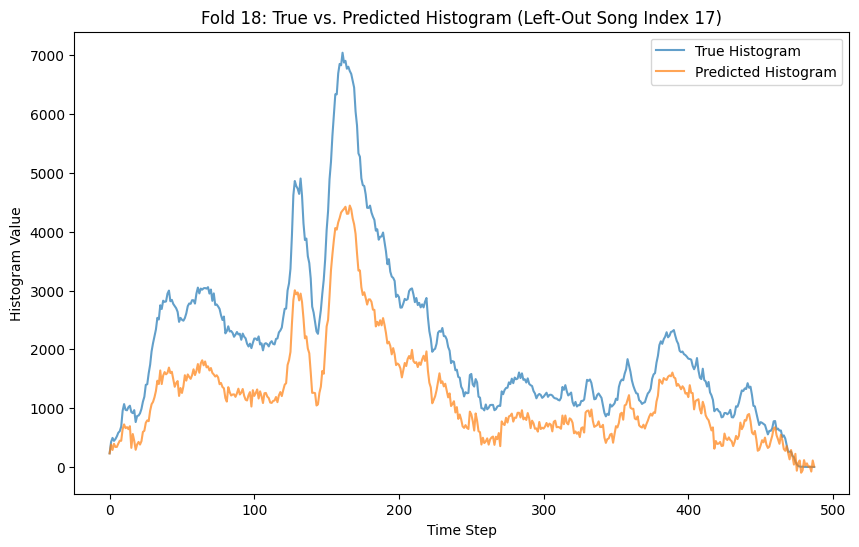

Fold 19: Leaving out song at index 18
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 29831.3789
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 26216.7129
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 28608.4512
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 28448.1504
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 29057.9609
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 32767.4707
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 31057.4004
Test MSE for this fold: 1139094.625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Test RMSE for this fold: 1067.2838134765625


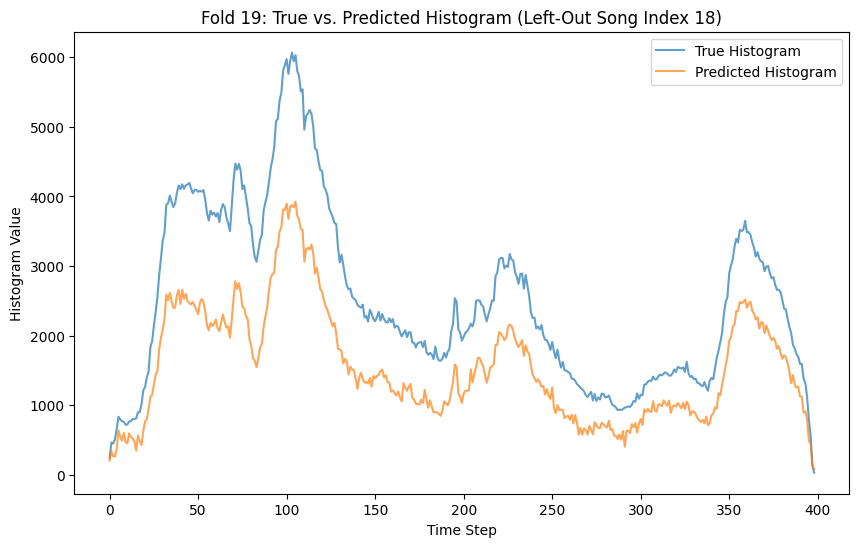

Fold 20: Leaving out song at index 19
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 29506.0098
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 30350.4941
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 28502.6445
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 30397.3887
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 25741.1074
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 28586.2441
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 28391.6816
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 29035.5566
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 25941.9434
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step - loss: 26593.0312
Test MSE for this fold: 1225949.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Test RMSE for this fold: 1107.2261962890625


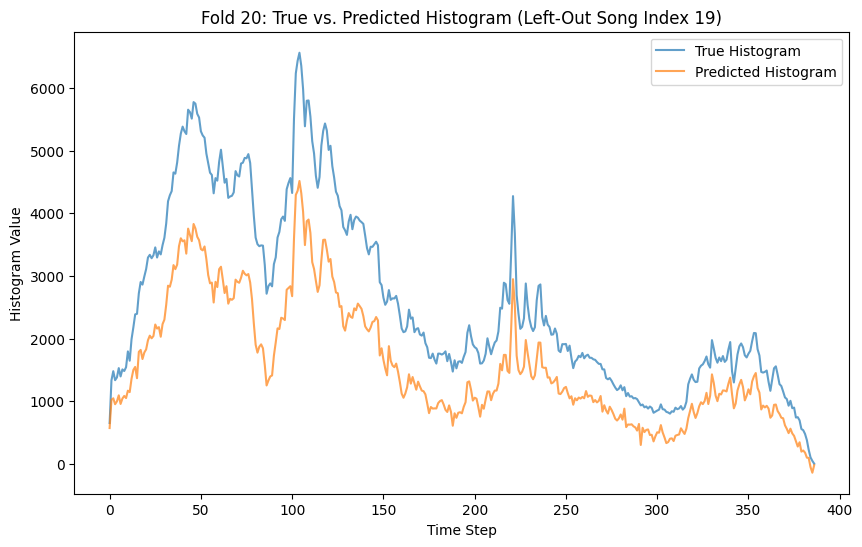

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

# Initialize Leave-One-Out cross-validator
loo = LeaveOneOut()

# Dynamically determine input shape from X
time_steps = X.shape[1]
features = X.shape[2]

# Custom masked loss function
def masked_mse(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, 0), K.floatx())  # Mask for non-zero values
    mse = K.square(y_pred - y_true) * mask             # Compute MSE only on non-zero values
    return K.sum(mse) / K.sum(mask)                    # Normalize by the number of non-zero values


model = Sequential()
model.add(Masking(mask_value=0., input_shape=(time_steps, features)))  # Mask zero-padded values
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(time_steps, activation='linear'))
model.compile(optimizer=Adam(learning_rate=0.001), loss=masked_mse)


for fold_number, (train_index, test_index) in enumerate(loo.split(X), start=1):

    print(f"Fold {fold_number}: Leaving out song at index {test_index[0]}")
    # Split the data into training and testing sets    X_train, X_test = X[train_index], X[test_index]
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    early_stopping = EarlyStopping(monitor='loss', patience=5)
    model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1, callbacks=[early_stopping])

    # Evaluate the model on the test set
    loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test MSE for this fold: {loss}")

    # Make predictions
    y_pred = model.predict(X_test).flatten()

    # Calculate RMSE (mask padded values)
    valid_indices = y_test.flatten() != 0  # Exclude padded values
    rmse = np.sqrt(mean_squared_error(y_test.flatten()[valid_indices], y_pred[valid_indices]))
    print(f"Test RMSE for this fold: {rmse}")

    # Plot the true vs. predicted histograms
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.flatten()[valid_indices], label='True Histogram', alpha=0.7)
    plt.plot(y_pred[valid_indices], label='Predicted Histogram', alpha=0.7)
    plt.xlabel('Time Step')
    plt.ylabel('Histogram Value')
    plt.title(f'Fold {fold_number}: True vs. Predicted Histogram (Left-Out Song Index {test_index[0]})')
    plt.legend()
    plt.show()
